In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [2]:
df = pd.read_csv('../Kaggle_dataset/ACWx5.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1/2/2013,56.889999,57.200001,56.230000,56.369999,47.750607,30700
1,1/3/2013,56.560001,56.639999,56.470001,56.500000,47.860737,30000
2,1/4/2013,56.490002,56.740002,56.490002,56.689999,48.021675,45700
3,1/7/2013,56.619999,56.619999,56.250000,56.349998,47.733665,49700
4,1/8/2013,56.380001,56.439999,56.250000,56.439999,47.809914,19200


In [3]:
short_window = int(0.025 * len(df))
long_window = int(0.05 * len(df))

signals = pd.DataFrame(index=df.index)
signals['signal'] = 0.0

signals['short_ma'] = df['Close'].rolling(window=short_window, min_periods=1, center=False).mean()
signals['long_ma'] = df['Close'].rolling(window=long_window, min_periods=1, center=False).mean()

signals['signal'][short_window:] = np.where(signals['short_ma'][short_window:] 
                                            > signals['long_ma'][short_window:], 1.0, 0.0)   
signals['positions'] = signals['signal'].diff()

signals

,signal,short_ma,long_ma,positions
0,0.0,56.369999,56.369999,NaN
1,0.0,56.434999,56.434999,0.0
2,0.0,56.519999,56.519999,0.0
3,0.0,56.477499,56.477499,0.0
4,0.0,56.469999,56.469999,0.0
...,...,...,...,...
1757,1.0,95.361818,94.773409,0.0
1758,1.0,95.377727,94.803750,0.0
1759,1.0,95.396364,94.837045,0.0
1760,1.0,95.415000,94.878523,0.0


In [4]:
def buy_stock(
    real_movement,
    signal,
    initial_money = 10000,
    max_buy = 1,
    max_sell = 1,
):
    """
    real_movement = actual movement in the real world
    delay = how much interval you want to delay to change our decision from buy to sell, vice versa
    initial_state = 1 is buy, 0 is sell
    initial_money = 1000, ignore what kind of currency
    max_buy = max quantity for share to buy
    max_sell = max quantity for share to sell
    """
    starting_money = initial_money
    states_sell = []
    states_buy = []
    current_inventory = 0

    def buy(i, initial_money, current_inventory):
        shares = initial_money // real_movement[i]
        if shares < 1:
            print(
                'day %d: total balances %f, not enough money to buy a unit price %f'
                % (i, initial_money, real_movement[i])
            )
        else:
            if shares > max_buy:
                buy_units = max_buy
            else:
                buy_units = shares
            initial_money -= buy_units * real_movement[i]
            current_inventory += buy_units
            print(
                'day %d: buy %d units at price %f, total balance %f'
                % (i, buy_units, buy_units * real_movement[i], initial_money)
            )
            states_buy.append(0)
        return initial_money, current_inventory

    for i in range(real_movement.shape[0] - int(0.025 * len(df))):
        state = signal[i]
        if state == 1:
            initial_money, current_inventory = buy(
                i, initial_money, current_inventory
            )
            states_buy.append(i)
        elif state == -1:
            if current_inventory == 0:
                    print('day %d: cannot sell anything, inventory 0' % (i))
            else:
                if current_inventory > max_sell:
                    sell_units = max_sell
                else:
                    sell_units = current_inventory
                current_inventory -= sell_units
                total_sell = sell_units * real_movement[i]
                initial_money += total_sell
                try:
                    invest = (
                        (real_movement[i] - real_movement[states_buy[-1]])
                        / real_movement[states_buy[-1]]
                    ) * 100
                except:
                    invest = 0
                print(
                    'day %d, sell %d units at price %f, investment %f %%, total balance %f,'
                    % (i, sell_units, total_sell, invest, initial_money)
                )
            states_sell.append(i)
    invest = ((initial_money - starting_money) / starting_money) * 100
    total_gains = initial_money - starting_money
    return states_buy, states_sell, total_gains, invest

In [5]:
states_buy, states_sell, total_gains, invest = buy_stock(df.Close, signals['positions'])

day 44: buy 1 units at price 60.259998, total balance 9939.740002
day 128, sell 1 units at price 60.220001, investment -0.066374 %, total balance 9999.960003,
day 177: buy 1 units at price 61.799999, total balance 9938.160004
day 267, sell 1 units at price 61.619999, investment -0.291263 %, total balance 9999.780003,
day 315: buy 1 units at price 64.410004, total balance 9935.369999
day 461, sell 1 units at price 68.610001, investment 6.520721 %, total balance 10003.980000,
day 471: buy 1 units at price 69.459999, total balance 9934.520000
day 627, sell 1 units at price 69.690002, investment 0.331131 %, total balance 10004.210003,
day 727: buy 1 units at price 70.279999, total balance 9933.930004
day 766, sell 1 units at price 65.930000, investment -6.189526 %, total balance 9999.860004,
day 810: buy 1 units at price 72.709999, total balance 9927.150005
day 951, sell 1 units at price 73.940002, investment 1.691656 %, total balance 10001.090008,
day 1034: buy 1 units at price 74.760002,

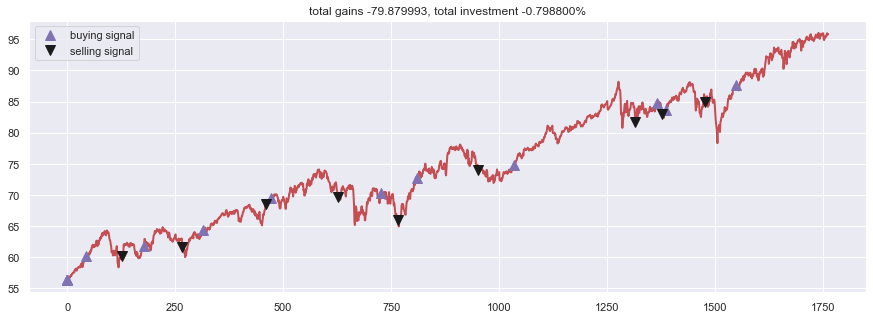

In [6]:
close = df['Close']
fig = plt.figure(figsize = (15,5))
plt.plot(close, color='r', lw=2.)
plt.plot(close, '^', markersize=10, color='m', label = 'buying signal', markevery = states_buy)
plt.plot(close, 'v', markersize=10, color='k', label = 'selling signal', markevery = states_sell)
plt.title('total gains %f, total investment %f%%'%(total_gains, invest))
plt.legend()
plt.show()